In [1]:
#importing libraries
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
import keras

In [3]:
img_size = 255
batches = 32
channels = 3


In [4]:
cotton_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/train",
    shuffle = True,
    image_size =(img_size,img_size),
    batch_size = batches,
    
)

Found 2293 files belonging to 4 classes.


2022-04-06 17:32:13.987027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 17:32:14.713475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 17:32:14.713783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 17:32:14.767522: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [8]:
cotton_ds.class_names

['diseased cotton leaf',
 'diseased cotton plant',
 'fresh cotton leaf',
 'fresh cotton plant']

In [9]:
len(cotton_ds)

72

In [10]:
def get_partitions_dataset(ds , train_split = 0.8 , val_split = 0.1 , test_split = 0.1 , shuffle = True , shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
        
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    
    return train_ds , val_ds , test_ds

In [11]:
training_ds , valid_ds , testing_ds = get_partitions_dataset(cotton_ds)

In [12]:
len(training_ds),len(valid_ds),len(testing_ds)

(57, 7, 8)

In [13]:
#optimizing

In [14]:
train_ds = training_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
test_ds = testing_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.experimental.AUTOTUNE )

In [15]:
data_augmentations = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size,img_size),
    layers.experimental.preprocessing.Rescaling(1.0/img_size),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
    
])

In [16]:
inputshape = (batches ,img_size , img_size , 3)
classes = 4

plant_model = keras.models.Sequential([
    data_augmentations,
    layers.Conv2D(filters = 32 , kernel_size = (3 , 3),activation = 'relu' , input_shape = inputshape),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(filters = 64 , kernel_size = (3,3)  , activation ='relu'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(filters = 128 , kernel_size = (3,3) , activation = 'relu'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(filters = 256, kernel_size = (3,3) , activation = 'relu'),
    layers.MaxPooling2D(pool_size = (2,2)),
    
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(units = 128 , activation = 'relu'),
    layers.Dropout(0.1),
    layers.Dense(units = 128 , activation = 'relu'),
    layers.Dropout(0.25),
    layers.Dense(units = classes , activation = 'softmax'),
    
])

plant_model.build(input_shape = inputshape)

In [17]:
plant_model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) , metrics = ['accuracy'])

In [18]:
plant_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 255, 255, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 253, 253, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 126, 126, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 124, 124, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 128)        

In [19]:
EPOCHS = 500

In [20]:
history = plant_model.fit(
    train_ds,
    epochs = EPOCHS,
    verbose = 1,
    validation_data = valid_ds

)

Epoch 1/500


2022-04-06 17:33:02.125565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 46 of 10000
2022-04-06 17:33:05.435682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-04-06 17:33:05.435725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-04-06 17:33:05.435852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-04-06 17:33:12.522023: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


57/57 [==============================] - 44s 199ms/step - loss: 1.2935 - accuracy: 0.4123 - val_loss: 1.1455 - val_accuracy: 0.4732
Epoch 2/500
57/57 [==============================] - 9s 165ms/step - loss: 1.1273 - accuracy: 0.4962 - val_loss: 1.1493 - val_accuracy: 0.5179
Epoch 3/500
57/57 [==============================] - 9s 166ms/step - loss: 0.9856 - accuracy: 0.5943 - val_loss: 0.8786 - val_accuracy: 0.6295
Epoch 4/500
57/57 [==============================] - 10s 169ms/step - loss: 0.7730 - accuracy: 0.6870 - val_loss: 0.8043 - val_accuracy: 0.6786
Epoch 5/500
57/57 [==============================] - 10s 167ms/step - loss: 0.6172 - accuracy: 0.7582 - val_loss: 0.6799 - val_accuracy: 0.7589
Epoch 6/500
57/57 [==============================] - 9s 167ms/step - loss: 0.5040 - accuracy: 0.8015 - val_loss: 0.5297 - val_accuracy: 0.7857
Epoch 7/500
57/57 [==============================] - 10s 170ms/step - loss: 0.4039 - accuracy: 0.8366 - val_loss: 0.4967 - val_accuracy: 0.7679
Epoch 8

Epoch 58/500
57/57 [==============================] - 9s 166ms/step - loss: 0.0936 - accuracy: 0.9627 - val_loss: 0.0567 - val_accuracy: 0.9777
Epoch 59/500
57/57 [==============================] - 9s 166ms/step - loss: 0.0918 - accuracy: 0.9666 - val_loss: 0.0541 - val_accuracy: 0.9732
Epoch 60/500
57/57 [==============================] - 9s 166ms/step - loss: 0.0816 - accuracy: 0.9726 - val_loss: 0.0836 - val_accuracy: 0.9777
Epoch 61/500
57/57 [==============================] - 9s 166ms/step - loss: 0.1183 - accuracy: 0.9616 - val_loss: 0.0921 - val_accuracy: 0.9598
Epoch 62/500
57/57 [==============================] - 9s 166ms/step - loss: 0.0592 - accuracy: 0.9808 - val_loss: 0.0845 - val_accuracy: 0.9777
Epoch 63/500
57/57 [==============================] - 9s 166ms/step - loss: 0.0866 - accuracy: 0.9704 - val_loss: 0.0594 - val_accuracy: 0.9777
Epoch 64/500
57/57 [==============================] - 9s 166ms/step - loss: 0.1209 - accuracy: 0.9616 - val_loss: 0.0977 - val_accuracy:

Epoch 115/500
57/57 [==============================] - 9s 166ms/step - loss: 0.0639 - accuracy: 0.9814 - val_loss: 0.0350 - val_accuracy: 0.9821
Epoch 116/500
57/57 [==============================] - 9s 166ms/step - loss: 0.0872 - accuracy: 0.9682 - val_loss: 0.0671 - val_accuracy: 0.9688
Epoch 117/500
57/57 [==============================] - 9s 166ms/step - loss: 0.0884 - accuracy: 0.9698 - val_loss: 0.0509 - val_accuracy: 0.9732
Epoch 118/500
57/57 [==============================] - 9s 166ms/step - loss: 0.0508 - accuracy: 0.9841 - val_loss: 0.0674 - val_accuracy: 0.9688
Epoch 119/500
57/57 [==============================] - 9s 166ms/step - loss: 0.0426 - accuracy: 0.9836 - val_loss: 0.0429 - val_accuracy: 0.9821
Epoch 120/500
57/57 [==============================] - 9s 166ms/step - loss: 0.0468 - accuracy: 0.9874 - val_loss: 0.2069 - val_accuracy: 0.9464
Epoch 121/500
57/57 [==============================] - 9s 166ms/step - loss: 0.0674 - accuracy: 0.9786 - val_loss: 0.0602 - val_ac

57/57 [==============================] - 10s 168ms/step - loss: 0.0199 - accuracy: 0.9923 - val_loss: 0.0245 - val_accuracy: 0.9955
Epoch 172/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0350 - accuracy: 0.9901 - val_loss: 0.0243 - val_accuracy: 0.9911
Epoch 173/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0894 - accuracy: 0.9753 - val_loss: 0.0868 - val_accuracy: 0.9554
Epoch 174/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0326 - accuracy: 0.9879 - val_loss: 0.1958 - val_accuracy: 0.9554
Epoch 175/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0318 - accuracy: 0.9896 - val_loss: 0.1237 - val_accuracy: 0.9554
Epoch 176/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0798 - accuracy: 0.9726 - val_loss: 0.1807 - val_accuracy: 0.9688
Epoch 177/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0375 - accuracy: 0.9863 - val_loss: 0.0084 - val_accuracy:

57/57 [==============================] - 10s 167ms/step - loss: 0.0650 - accuracy: 0.9836 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 228/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0945 - accuracy: 0.9726 - val_loss: 0.0621 - val_accuracy: 0.9777
Epoch 229/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0363 - accuracy: 0.9890 - val_loss: 0.0286 - val_accuracy: 0.9911
Epoch 230/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0202 - accuracy: 0.9907 - val_loss: 0.0490 - val_accuracy: 0.9777
Epoch 231/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0241 - accuracy: 0.9923 - val_loss: 0.0154 - val_accuracy: 0.9911
Epoch 232/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0318 - accuracy: 0.9890 - val_loss: 0.0578 - val_accuracy: 0.9821
Epoch 233/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0147 - accuracy: 0.9945 - val_loss: 0.0054 - val_accuracy:

57/57 [==============================] - 10s 172ms/step - loss: 0.0248 - accuracy: 0.9934 - val_loss: 0.0449 - val_accuracy: 0.9866
Epoch 284/500
57/57 [==============================] - 10s 170ms/step - loss: 0.0241 - accuracy: 0.9918 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 285/500
57/57 [==============================] - 10s 168ms/step - loss: 0.0186 - accuracy: 0.9929 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 286/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0062 - accuracy: 0.9989 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 287/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0101 - accuracy: 0.9978 - val_loss: 0.0379 - val_accuracy: 0.9821
Epoch 288/500
57/57 [==============================] - 10s 170ms/step - loss: 0.0624 - accuracy: 0.9775 - val_loss: 0.0294 - val_accuracy: 0.9911
Epoch 289/500
57/57 [==============================] - 10s 171ms/step - loss: 0.0349 - accuracy: 0.9896 - val_loss: 0.0115 - val_accuracy:

57/57 [==============================] - 10s 167ms/step - loss: 0.0167 - accuracy: 0.9967 - val_loss: 0.0198 - val_accuracy: 0.9955
Epoch 340/500
57/57 [==============================] - 10s 168ms/step - loss: 0.0091 - accuracy: 0.9967 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 341/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0203 - accuracy: 0.9929 - val_loss: 0.0090 - val_accuracy: 0.9955
Epoch 342/500
57/57 [==============================] - 10s 170ms/step - loss: 0.1259 - accuracy: 0.9677 - val_loss: 0.1100 - val_accuracy: 0.9643
Epoch 343/500
57/57 [==============================] - 10s 169ms/step - loss: 0.0357 - accuracy: 0.9868 - val_loss: 0.0437 - val_accuracy: 0.9821
Epoch 344/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0268 - accuracy: 0.9896 - val_loss: 0.0192 - val_accuracy: 0.9911
Epoch 345/500
57/57 [==============================] - 10s 173ms/step - loss: 0.0085 - accuracy: 0.9967 - val_loss: 0.0075 - val_accuracy:

57/57 [==============================] - 10s 167ms/step - loss: 0.0086 - accuracy: 0.9967 - val_loss: 0.0087 - val_accuracy: 0.9955
Epoch 396/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0285 - accuracy: 0.9940 - val_loss: 0.1670 - val_accuracy: 0.9509
Epoch 397/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0515 - accuracy: 0.9852 - val_loss: 0.0574 - val_accuracy: 0.9866
Epoch 398/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0386 - accuracy: 0.9874 - val_loss: 0.0139 - val_accuracy: 0.9955
Epoch 399/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0246 - accuracy: 0.9951 - val_loss: 0.0119 - val_accuracy: 0.9955
Epoch 400/500
57/57 [==============================] - 9s 167ms/step - loss: 0.0089 - accuracy: 0.9978 - val_loss: 0.0163 - val_accuracy: 0.9955
Epoch 401/500
57/57 [==============================] - 9s 167ms/step - loss: 0.0478 - accuracy: 0.9841 - val_loss: 0.0184 - val_accuracy: 0

57/57 [==============================] - 10s 167ms/step - loss: 0.0224 - accuracy: 0.9945 - val_loss: 0.0307 - val_accuracy: 0.9866
Epoch 452/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0152 - accuracy: 0.9956 - val_loss: 0.0555 - val_accuracy: 0.9866
Epoch 453/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0326 - accuracy: 0.9940 - val_loss: 0.0758 - val_accuracy: 0.9911
Epoch 454/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0760 - accuracy: 0.9825 - val_loss: 0.0115 - val_accuracy: 1.0000
Epoch 455/500
57/57 [==============================] - 9s 167ms/step - loss: 0.0104 - accuracy: 0.9978 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 456/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0055 - accuracy: 0.9984 - val_loss: 0.0079 - val_accuracy: 0.9955
Epoch 457/500
57/57 [==============================] - 10s 167ms/step - loss: 0.0084 - accuracy: 0.9967 - val_loss: 0.0035 - val_accuracy: 

In [21]:
scores = plant_model.evaluate(test_ds)

8/8 [==============================] - 2s 67ms/step - loss: 0.0923 - accuracy: 0.9805


In [22]:
scores

[0.09226317703723907, 0.98046875]

In [23]:
history

In [24]:
history.params

{'verbose': 1, 'epochs': 500, 'steps': 57}

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

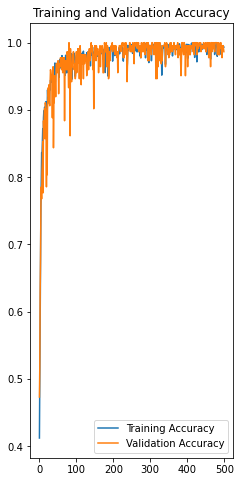

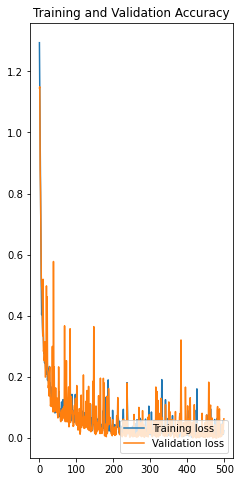

In [27]:
plt.figure(figsize = (8,8))
plt.subplot( 1 , 2 , 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize = (8,8))
plt.subplot( 1 , 2 , 1)
plt.plot(range(EPOCHS), loss, label = 'Training loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.show()

In [28]:
#saving the model for further use
from tensorflow.keras.models import load_model
plant_model.save('plant_predt.h5')

In [ ]:
Y_pred

In [29]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1
